# Bike Sharing Rebalancing Problem

## Indice


- [Indice](#Indice)
- [Introduzione](#Introduzione)
- [Inizializzazione del problema](#Inizializzazione-del-problema)
    - [Plot delle stazioni e del deposito](#Plot-delle-stazioni-e-del-deposito)
- [Modelli con CPLEX](#Modelli-con-CPLEX)
    - [Formulazione 1](#Formulazione-1)
        - [Visualizzazione del percorso con le domande](#Visualizzazione-del-percorso-con-le-domande-1)
        - [Visualizzazione del percorso con il valore $\theta$](#Visualizzazione-del-percorso-con-il-valore-theta)
    - [Formulazione 2](#Formulazione-2)
        - [Visualizzazione del percorso con le domande](#Visualizzazione-del-percorso-con-le-domande-2)
        - [Visualizzazione del percorso con il valore $f_{ij}$](#Visualizzazione-del-percorso-con-il-valore-$f_{ij}$)
    - [Formulazione 3](#Formulazione-3)
        - [Visualizzazione del percorso con le domande](#Visualizzazione-del-percorso-con-le-domande-3)
- [Valutazione](#Valutazione)



## Introduzione

Il problema del *bike sharing rebalancing* è un problema tipico del bike sharing. Questi sistemi offrono un servizio di mobilità mettendo a disposizione dei mezzi in diverse stazioni, in questo caso le biciclette, rendendo possibile il loro utilizzo condiviso tra gli utenti del servizio. In questo modo, un utente può prendere una bicicletta da una stazione, utilizzarla, e successivamente lasciarla nella stessa stazione di partenza o in un'altra disponibile, pagando il servizio in base al tempo di utilizzo del mezzo. Per il gestore questo tipo di sistema ha un costo che dipende da tanti fattori come, ad esempio, la manutenzione dei mezzi, la loro assicurazione e la loro redistribuzione sul territorio. 

Per mantenere una giusta redistribuzione delle biciclette bisogna garantire la presenza di un certo numero di mezzi ad ogni stazione, così come l'assenza di altri, in modo da consentire agli utenti di poter lasciare la bicicletta in uno stallo vuoto. In generale, dovrebbero esserci degli slot occupati e degli slot vuoti. La redistribuzione parte da un deposito, dove i veicoli adibiti allo spostamento delle biciclette, che posso essere pieni e vuoti già in partenza, possono effettuare 3 manovre:
1. Una stazione nel tragitto ha una *domanda negativa*, quindi in mancanza di mezzi, in questo caso il veicolo scaricherà le bici necessarie per raggiungere l'equilibrio;
2. Una stazione nel tragitto ha una *domanda positiva*, quindi ha un surplus di mezzi, in questo caso il veicolo caricherà al suo interno i veicoli in più;
3. Una stazione nel tragitto ha una *domanda nulla*, quindi è in equilibrio, in questo caso il veicolo non deve effettuare nessuna manovra.

Il problema da risolvere è quello di trovare il percorso migliore per effettuare il ribilanciamento delle stazioni, cercando di minimizzare i costi che il gestore del bike sharing dovrà sostenere per effettuare questa operazione. Si può quindi definire un problema di ottimizzazione per risolvere questo problema.


Il problema di ottimizzazione della redistribuzione prende il nome di Bike sharing Rebalancing Problem (BRP), una versione più specifica del problema del commesso viaggiatore, ed è caratterizzato dai seguenti elementi: 

- $V$ è il set di vertici
- $A$ è il set di archi
- $n$ è il numero di stazioni
- $m$ è il numero di veicoli
- $Q$ è la capacità dei veicoli
- $q_i$ è la domanda al vertice $i$
- $c_{ij}$ è il costo dell'arco $(i,j)$

Di base, il problema di ottimizzazione si occupa di minimizzare la seguente funzione obiettivo, dove i costi possono essere scelti arbitrariamente, nel nosto caso specifico si utilizzano delle semplici distanze euclidee. La funzione obiettivo è calcolata facendo la sommatoria del prodotto del costo $c_{ij}$ dell'arco moltiplicato per $x$, che indica l'utilizzo di quello specifico arco. La formulazione è:

$$\begin{align}
\min \quad & \sum_{i,j \in V} c_{ij} x_{ij} && (1)\\
\end{align}$$

Il paper proposto per la modellazione del BRP presenta diverse formulazioni. Noi ci siamo occupati di implementare tre delle quattro formulazioni proposte, non tenendo in considerazione l'algoritmo di Branch&Cut. Ogni formulazione si basa su dei vincoli, certi sono in comune tra tutte le formulazioni, mentre altri sono specifici per ognuna di esse.
Oltre alla funzione obiettivo (1), i vincoli comuni a tutte le formulazioni sono:

$$\begin{align}
\text{vin.} \quad & \sum_{i\in V} x_{ij} = 1  && j \in V\setminus \{0\}  && (2)\\
& \sum_{i\in V} x_{ji} = 1 && j \in V\setminus \{0\} && (3) \\
& \sum_{j\in V} x_{0j} \leq m && && (4)\\
& \sum_{j\in V\setminus\{0\}} x_{0j} = \sum_{j\in V\setminus\{0\}} x_{j0} && && (5)\\
& x_{ij} \in \{0,1\} && i,j \in V && (7)
\end{align}$$

I vincoli (2) e (3) impongono un'unica visita ad ogni nodo della rete, fatta eccezione per il deposito. I vincoli (4) e (5) garantiscono, rispettivamente, che al più $m$ veicoli partano dal deposito, e che tutti i veicoli impiegati per la redistribuzione rientrino al deposito alla fine del loro percorso. Il vincolo (7) implica semplicemente che le componenti di $x$ abbiano un valore pari a $0$, se non si passa dal nodo $i$ al nodo $j$, oppure a $1$, se si passa dal nodo $i$ al nodo $j$.

Per la risoluzione del nostro problema abbiamo deciso di utilizzare Python con la libreria docplex, che può essere usata per risolvere problemi di programmazione lineare direttamente dal codice Python.

Il progetto è diviso in altre 3 sezioni principali: nella prima andiamo ad inizializzare il problema per renderlo modellabile attraverso Python; nella seconda parte modelliamo le prime 3 formulazioni proposte dall'articolo, ogni formulazione avrà il proprio risultato e la visualizzazione del percorso; l'ultima sezione si comporta di test, andiamo quindi ad analizzare le performance delle formulazioni. 


## Inizializzazione del problema


Per prima cosa andiamo quindi a generare in modo più o meno arbitrario gli elementi caratterizanti di questo problema di ottimizzazione. Oltre agli elementi già sopra definiti, aggiungiamo anche un insieme $N$, che contiene tutte le stazioni, ad esclusione del deposito. Questo insieme ci sarà utile più avanti nelle formulazioni dei vincoli. La domanda $q_i$ è generata casualmente ed i costi $c_{ij}$ vengono rappresentati come distanza euclidee tra i diversi nodi del sistema.

In [1]:
import numpy as np

In [2]:
rnd = np.random
#rnd.seed(0)

In [3]:
n = 5                                            # numero stazioni
N = [i for i in range(1, n+1)]                   # stazioni senza deposito
V = [0] + N                                      # nodi: stazioni + deposito
A = [(i, j) for i in V for j in V]               # archi
m = 2                                            # numero veicoli
Q = 10                                           # capacità dei veicoli
q = {i: rnd.randint(-Q, Q) for i in V}           # domanda ai vertici
q[0] = 0

# generazione casuale coordinate
loc_x = rnd.rand(len(V))*200
loc_y = rnd.rand(len(V))*100

c = {(i, j): 
        np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) 
             for i, j in A}                      # costi degli archi

### Plot delle stazioni e del deposito

Eseguiamo un plot delle stazioni generate casualmente, insieme ad ogni nodo è anche visualizzata la relativa domanda

In [4]:
import matplotlib.pyplot as plt

(15.132157511141715, 206.8319058208281, 24.771896561591458, 96.128412235803)

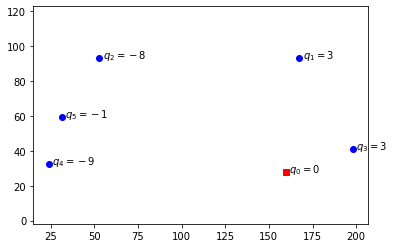

In [5]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

***

## Modelli con CPLEX

In questa sezione andremo a modellare le formulazioni, per far ciò, utilizzeremo delle chiamate a metodi definiti nella libreria docplex. Tra questi metodi possiamo vedere:
- Il metodo *binary_var_dict*, che crea una variabile decisionale binaria con nome definito nel campo "name". Questa variabile decisionale sarà definita come un dizionario, dove le chiavi vengono passate come parametro. In questo caso le chiavi saranno tutti gli archi;
- Il metodo *continous_var_dict*, funziona come la binary_var_dict, ma crea una variabile di tipo continua;
- Il metodo *minimize* che definisce la funzione obiettivo;
- Il metodo *add_constraints* che ci fa aggiungere un certo numero di vincoli, che viene passato come parametro;

Esistono tanti altri metodi utilizzabili per semplificare la modellazione del problema, per esempio possiamo usare *sum* per eseguire una sommatoria o possiamo utilizzare *min* per calcolare il minimo degli elementi passati come parametri. Non indichiamo tutte le funzioni usate, perchè sono autoesplicative.

In [6]:
from docplex.mp.model import Model
import itertools

### Formulazione 1
Alla formulazione 1 si aggiungono i seguenti vincoli:

$$\begin{align}
& \sum_{i\in S}\sum_{j\in S} x_{ij} \leq |S|-1 && S\subseteq V \setminus \{0\},  S\neq\emptyset && (6)\\
& max\{0,q_j\} \leq \theta_j \leq min\{Q,Q+q_j\} && j \in V && (10) \\
& \theta_j \geq \theta_i + q_j - M(1-x_{ij}) && i \in V, j \in V \setminus\{0\} && (11)\\
& \theta_i \geq \theta_j - q_j - M(1-x_{ij}) && i \in V \setminus\{0\}, j \in V && (12)\\
\end{align}$$

La serie di vincoli definita in (6) definisce i vincoli di subtour elimination che impongono la connettività della soluzione, per evitare che vi siano veicoli che partano da una stazione (non dal deposito). Il vincolo (10) si occupa semplicemente di imporre dei limiti, uno inferiore e uno superiore, al carico che può trasportare un veicolo, mentre i vincoli (11) e (12) sono dei vincoli lineari che impongono che il carico in uscita da un nodo sia pari a quello di entrata più la domanda del nodo di uscita, nel caso in cui la componente $x_{ij}$ sia pari a $1$.

Nei vincoli (10), (11) e (12) viene definita una nuova variabile continua $\theta_j$, la quale rappresenta il carico di un veicolo dopo che questo ha visitato il nodo $j$. Il valore di questa variabile va tenuto aggiornato durante tutto il tragitto tenendo in considerazione il fatto che, se il veicolo passa per l'arco $(i, j)$, allora $\theta_j$  dovrà essere pari alla somma tra il carico precedente al nodo $i$, quindi $\theta_i$, e la domanda al nodo $j$, definita come $q_j$.

In [7]:
f1 = Model('BikeSharingRebalancing-F1')

In [8]:
# variabili decisionali
x = f1.binary_var_dict(A, name='x')
theta = f1.continuous_var_dict(V, name='theta')

In [9]:
# vincoli

#1
f1.minimize(f1.sum(c[i, j]*x[i, j] for i in V for j in V))

#2
f1.add_constraints(f1.sum(x[i, j] for i in V) == 1 for j in N)

#3
f1.add_constraints(f1.sum(x[j, i] for i in V) == 1 for j in N)

#4
f1.add_constraint(f1.sum(x[0, j] for j in V) <= m )

#5
f1.add_constraint(f1.sum(x[0, j] for j in N) == f1.sum(x[i, 0] for i in N))

#6
for i in range(1, len(N) + 1):
    for S in itertools.permutations(N, i):
        f1.add_constraint(f1.sum(x[i, j] for j in S for i in S) <= len(S)-1)
        
#7 - implementato nella definizione di x

#10
f1.add_constraints((f1.max(0, q[j]) <= theta[j]) for j in V)
f1.add_constraints((theta[j] <= f1.min(Q, Q+q[j])) for j in V)

#11
f1.add_constraints(theta[j] >= theta[i] + q[j] - f1.min(Q, Q+q[j])*(1-x[i, j]) for i in V for j in N)

#12
f1.add_constraints(theta[i] >= theta[j] - q[j] - f1.min(Q, Q-q[j])*(1-x[i, j]) for i in N for j in V)

#mdl.parameters.timelimit = 15
solutionF1 = f1.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 341 rows and 9 columns.
MIP Presolve modified 32 coefficients.
Reduced MIP has 68 rows, 33 columns, and 295 nonzeros.
Reduced MIP has 28 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.02 ticks)
Found incumbent of value 699.922343 after 0.02 sec. (1.44 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 68 rows, 33 columns, and 295 nonzeros.
Reduced MIP has 28 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.18 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Clique table members: 16.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.1

In [10]:
print(solutionF1)

solution for: BikeSharingRebalancing-F1
objective: 636.039
x_0_2=1
x_0_5=1
x_1_3=1
x_2_1=1
x_3_0=1
x_4_0=1
x_5_4=1
theta_1=5.000
theta_2=2.000
theta_3=8.000
theta_5=9.000



In [11]:
print(solutionF1.solve_details)

status  = integer optimal solution
time    = 0.172 s.
problem = MILP
gap     = 0%



#### Visualizzazione del percorso con le domande

In [12]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]

(15.132157511141715, 206.83190582082813, 24.771896561591454, 96.12841223580301)

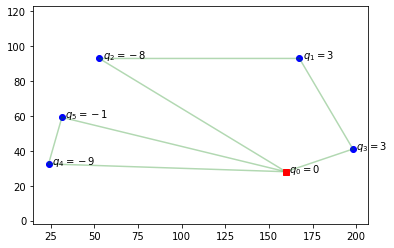

In [13]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

#### Visualizzazione del percorso con il valore theta

(15.132157511141715, 206.83190582082813, 24.771896561591454, 96.12841223580301)

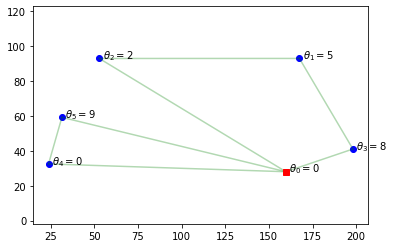

In [14]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in V:
    plt.annotate('$θ_%d=%2.f$' % (i, theta[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

In [15]:
del f1
del solutionF1
del x
del theta

***

### Formulazione 2
Alla formulazione 2 si aggiungono i seguenti vincoli:

$$\begin{align}
& \sum_{i\in S}\sum_{j\in S} x_{ij} \leq |S|-1 && S\subseteq V \setminus \{0\},  S\neq\emptyset && (6)\\
& \sum_{i\in V}f_{ji} - \sum_{i\in V} f_{ij} = q_j && j \in V\setminus\{0\} && (13)\\
& max\{0, q_i, -q_j\}x_{ij} \leq f_{ij} \leq min\{Q, Q+q_i, Q - q_j\}x_{ij} && (i, j) \in A && (14)
\end{align}$$

Anche in questo caso troviamo i vincoli per la subtour elimination (6), in comune con la formulazione 1. Il vincolo (13) modella l'equilibrio dei flussi sugli archi entranti ed uscenti da un certo nodo. Il vincolo (14) impone invece il lower e l'upper bounds del flusso su ogni arco.

Nei vincoli (13) e (14) viene introdotta una nuova variabile $f_{ij}$, che rappresenta il flusso nell'arco $(i, j)$, ossia il carico sul veicolo che passa appunto sul percorso tra i nodi $i$ e $j$.

In [16]:
f2 = Model('BikeSharingRebalancing-F2')

In [17]:
# variabili decisionali
x = f2.binary_var_dict(A, name='x')
f = f2.continuous_var_dict(A, name='f')

In [18]:
# vincoli

#1
f2.minimize(f2.sum(c[i, j]*x[i, j] for i in V for j in V))

#2
f2.add_constraints(f2.sum(x[i, j] for i in V) == 1 for j in N)

#3
f2.add_constraints(f2.sum(x[j, i] for i in V) == 1 for j in N)

#4
f2.add_constraint(f2.sum(x[0, j] for j in V) <= m )

#5
f2.add_constraint(f2.sum(x[0, j] for j in N) == f2.sum(x[i, 0] for i in N))

#6
for i in range(1, len(N) + 1):
    for S in itertools.permutations(N, i):
        f2.add_constraint(f2.sum(x[i, j] for j in S for i in S) <= len(S)-1)

#7 - implementato nella definizione di x
        
#13
f2.add_constraints((f2.sum(f[j, i] for i in V) - f2.sum(f[i, j] for i in V)) == q[j] for j in N)

#14
f2.add_constraints(((f2.max(0, q[i], -q[j])*x[i, j]) <= f[i, j]) for i, j in A)
f2.add_constraints((f[i,j] <= (f2.min(Q, Q+q[i], Q-q[j])*x[i, j])) for i, j in A)

#mdl.parameters.timelimit = 15
solutionF2 = f2.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Found incumbent of value 679.628268 after 0.00 sec. (0.17 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 332 rows and 16 columns.
Aggregator did 10 substitutions.
Reduced MIP has 72 rows, 46 columns, and 348 nonzeros.
Reduced MIP has 25 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.36 ticks)
Probing time = 0.00 sec. (0.08 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 72 rows, 46 columns, and 348 nonzeros.
Reduced MIP has 25 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.22 ticks)
Probing time = 0.00 sec. (0.09 ticks)
Clique table members: 16.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.19 ti

In [19]:
print(solutionF2)

solution for: BikeSharingRebalancing-F2
objective: 636.039
x_0_3=1
x_0_4=1
x_1_2=1
x_2_0=1
x_3_1=1
x_4_5=1
x_5_0=1
f_0_3=2.000
f_0_4=10.000
f_1_2=8.000
f_3_1=5.000
f_4_5=1.000



In [20]:
print(solutionF2.solve_details)

status  = integer optimal solution
time    = 0.172 s.
problem = MILP
gap     = 0%



#### Visualizzazione del percorso con le domande

In [21]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]

(15.132157511141715, 206.83190582082813, 24.771896561591454, 96.12841223580301)

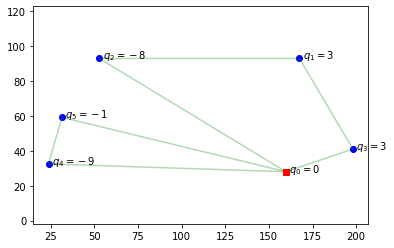

In [22]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

#### Visualizzazione del percorso con il valore $f_{ij}$

(15.132157511141715, 206.83190582082813, 24.771896561591454, 96.12841223580301)

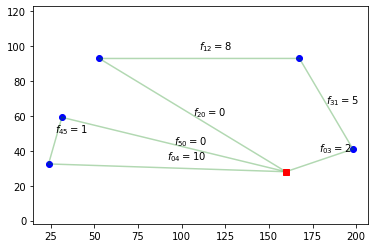

In [23]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
    if i > j:
        plt.annotate('$f_{%d%d}=%2.f$' % (i, j, f[i, j]), ((loc_x[i]+loc_x[j])/2, (loc_y[i]+loc_y[j])/2))
    else:
        plt.annotate('$f_{%d%d}=%2.f$' % (i, j, f[i, j]), ((loc_x[i]+loc_x[j])/2, (loc_y[i]+loc_y[j])/2+5))
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

***

### Formulazione 3
Alla formulazione 3 si aggiunge il seguente vincolo:

$$\begin{align}
& \sum_{i \in S}\sum_{j \in S}x_{ij} \leq |S| - max \bigg\{1, \bigg \lceil \frac{|\sum_{i \in S}q_i|}{Q} \bigg \rceil \bigg\} && S \subseteq V \setminus \{0\}, S\neq\emptyset && (15)
\end{align}$$

Il vincolo (15) impone che, per ogni sottoinsieme S di V, il numero di archi aventi gli estremi in S non sia superiore alla cardinalità meno il numero minimo di veicoli necessari per servire il sottoinsieme S.

In [24]:
f3 = Model('BikeSharingRebalancing-F3')

In [25]:
# variabili decisionali

x = f3.binary_var_dict(A, name='x')

f = f3.continuous_var_dict(A, name='f')

In [26]:
import math
# vincoli

#1
f3.minimize(f3.sum(c[i, j]*x[i, j] for i in V for j in V))

#2
f3.add_constraints(f3.sum(x[i, j] for i in V) == 1 for j in N)

#3
f3.add_constraints(f3.sum(x[j, i] for i in V) == 1 for j in N)

#4
f3.add_constraint(f3.sum(x[0, j] for j in V) <= m)

#5
f3.add_constraint(f3.sum(x[0, j] for j in N) == f3.sum(x[i, 0] for i in N))

#7 - implementato nella definizione di x

#15
for i in range(1, len(N) + 1):
    for S in itertools.permutations(N, i):
        ceil = math.ceil(abs(sum(q[i] for i in S)))
        f3.add_constraint(f3.sum(x[i, j] for j in S for i in S) <= len(S)-f3.max(1, ceil/Q))

#mdl.parameters.timelimit = 15
solutionF3 = f3.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 314 rows and 44 columns.
MIP Presolve modified 210 coefficients.
Reduced MIP has 23 rows, 28 columns, and 133 nonzeros.
Reduced MIP has 28 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.97 ticks)
Found incumbent of value 699.922343 after 0.00 sec. (1.26 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 23 rows, 28 columns, and 133 nonzeros.
Reduced MIP has 28 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.08 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Clique table members: 16.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0

In [27]:
print(solutionF3)

solution for: BikeSharingRebalancing-F3
objective: 636.039
x_0_2=1
x_0_5=1
x_1_3=1
x_2_1=1
x_3_0=1
x_4_0=1
x_5_4=1



In [28]:
print(solutionF3.solve_details)

status  = integer optimal solution
time    = 0.047 s.
problem = MILP
gap     = 0%



#### Visualizzazione del percorso con le domande

In [29]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]

(15.132157511141715, 206.83190582082813, 24.771896561591454, 96.12841223580301)

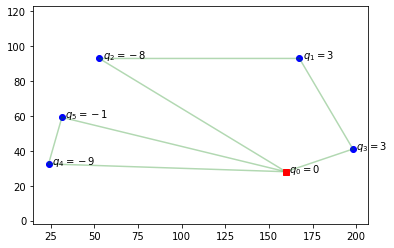

In [30]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

***

## Valutazione


Per effettuare la valutazione abbiamo utilizzato il dataset *9Bergamo12* ed il dataset *12Parma10*, entrambi contengono il numero di nodi totali, il vettore della domanda, la capacità dei veicoli e la matrice dei costi tra i diversi nodi. La quantità di vertici non ci consetiva di concludere l'eleborazione, abbiamo quindi ridotto, in modo artificiale, il numero di nodi della rete. Nello specifico abbiamo creato un sottoinsieme con con 10, 9, 8 e 5 vertici. Questa diminuzione dei nodi è stata resa necessaria a causa dei vincoli (6) e (15), che portano alla generazione di un numero esponenziale di sottoinsiemi dei nodi e riempie velocemente la memoria RAM, portando ad un'interruzione improvvisa del programma con un numero superiore a 10 nodi, dopo 40 minuti di esecuzione.

In un lavoro futuro sarebbe interessante andare a studiare il funzionamento delle *lazy constraint* in CPLEX, che permetterebbero di risolvere il problema, senza generare anticipatamente tutti i vicoli con tutti i sottoinsiemi possibili, ma aggiungerli incrementalmente solo quando le soluzioni trovate presentano dei subtour. 

Nella [Tabella 1](#tabella1) e nella [Tabella 2](#tabella2) sono riassunti i risultati della nostra valutazione, per ogni istanza del dataset e per le diverse dimensioni, abbiamo riportato il tempo della creazione dei vincoli più il tempo per la risoluzione del problema, il gap all'ottimo ed il gap percentuale tra la funzione obiettivo ottima del problema di PLI e quella del suo rilassamento continuo. Tutti i test sono stati eseguiti con la piattaforma IBM Cloud con il tool di decision optimization.


<table>  
  <caption align="bottom" id="tabella1">Tabella 1. Risultati dei test per 9Bergamo12</caption>
  <col>
  <colgroup span="3" style="border-right: 1px solid #c5c5c5;"></colgroup>
  <colgroup span="3" style="border-right: 1px solid #c5c5c5;"></colgroup>
  <tr>
    <td rowspan="2" style="text-align:center; font-weight: bold;">V</td>
    <th colspan="3" scope="colgroup" style="text-align:center; border-right: none !important;">F1</th>
    <th colspan="3" scope="colgroup" style="text-align:center">F2</th>
    <th colspan="3" scope="colgroup" style="text-align:center">F3</th>
  </tr>
  <tr>
    <th scope="col">$Tempo$</th>
    <th scope="col">$Gap$</th>
    <th scope="col">$Gap_r$</th>
    <th scope="col">$Tempo$</th>
    <th scope="col">$Gap$</th>
    <th scope="col">$Gap_r$</th>
    <th scope="col">$Tempo$</th>
    <th scope="col">$Gap$</th>
    <th scope="col">$Gap_r$</th>
  </tr>
  <tr>
    <th scope="row">5</th>
    <td>5s + 0s</td>
    <td>0%</td>
    <td>100%</td>
    <td>2s + 0s</td>
    <td>0%</td>
    <td>62.02%</td>
    <td>2s + 0s</td>
    <td>0%</td>
    <td>100%</td>
  </tr>
  <tr>
    <th scope="row">8</th>
    <td>4s + 0s</td>
    <td>0%</td>
    <td>100%</td>
    <td>4s + 0s</td>
    <td>0%</td>
    <td>72.92%</td>
    <td>5s + 0s</td>
    <td>0%</td>
    <td>100%</td>
  </tr>
  <tr>
    <th scope="row">9</th>
    <td>21s + 2s</td>
    <td>0%</td>
    <td>100%</td>
    <td>20s + 2.56s</td>
    <td>0%</td>
    <td>72.55%</td>
    <td>21s + 2s</td>
    <td>0%</td>
    <td>100%</td>
  </tr>
  <tr>
    <th scope="row">10</th>
    <td>3m12s + 26.2s</td>
    <td>0%</td>
    <td>100%</td>
    <td>3m20s + 32.70s</td>
    <td>0%</td>
    <td>74.07%</td>
    <td>3m30s + 28s</td>
    <td>0%</td>
    <td>100%</td>
  </tr>
</table>



<table>  
  <caption align="bottom" id="tabella2">Tabella 2. Risultati dei test per 12Parma10</caption>
  <col>
  <colgroup span="3" style="border-right: 1px solid #c5c5c5;"></colgroup>
  <colgroup span="3" style="border-right: 1px solid #c5c5c5;"></colgroup>
  <tr>
    <td rowspan="2" style="text-align:center; font-weight: bold;">V</td>
    <th colspan="3" scope="colgroup" style="text-align:center; border-right: none !important;">F1</th>
    <th colspan="3" scope="colgroup" style="text-align:center">F2</th>
    <th colspan="3" scope="colgroup" style="text-align:center">F3</th>
  </tr>
  <tr>
    <th scope="col">$Tempo$</th>
    <th scope="col">$Gap$</th>
    <th scope="col">$Gap_r$</th>
    <th scope="col">$Tempo$</th>
    <th scope="col">$Gap$</th>
    <th scope="col">$Gap_r$</th>
    <th scope="col">$Tempo$</th>
    <th scope="col">$Gap$</th>
    <th scope="col">$Gap_r$</th>
  </tr>
  <tr>
    <th scope="row">5</th>
    <td>3s + 0s</td>
    <td>0%</td>
    <td>100%</td>
    <td>3s + 0s</td>
    <td>0%</td>
    <td>90.77%</td>
    <td>2s + 0</td>
    <td>0%</td>
    <td>100%</td>
  </tr>
  <tr>
    <th scope="row">8</th>
    <td>6s + 0.28s</td>
    <td>0%</td>
    <td>100%</td>
    <td>10s + 0.23s</td>
    <td>0%</td>
    <td>100%</td>
    <td>4s + 0.4s</td>
    <td>0%</td>
    <td>100%</td>
  </tr>
  <tr>
    <th scope="row">9</th>
    <td>27s + 3.25s</td>
    <td>0%</td>
    <td>100%</td>
    <td>27s + 2.66s</td>
    <td>0%</td>
    <td>100%</td>
    <td>23s+ 2.23s</td>
    <td>0%</td>
    <td>100%</td>
  </tr>
  <tr>
    <th scope="row">10</th>
    <td>3.03min + 34.19s</td>
    <td>0%</td>
    <td>100%</td>
    <td>4.18m + 34s</td>
    <td>0%</td>
    <td>100%</td>
    <td>3.26m + 27s </td>
    <td>0%</td>
    <td>100%</td>
  </tr>
</table>

Da come si può vedere dai dati delle tabelle, la maggior parte del tempo è utilizzato per creare i vincoli del problema, nello specifico, creare tutte le combinazioni di vertici, neccessari ai vincoli (6) e (15). Dai test effettuati, le formulazioni F1 ed F3 sembrano migliori della F2, per quanto riguarda il tempo; invece F2 ha un $Gap_r$ minore. Visto l'esiguo numero di nodi utilizzabili nelle diverse istanze, non è possibile capire appieno le potenzialità delle diverse formulazioni.


Per completezza inseriamo il codice utilizzato per leggere i dataset ed inizializzare le variabili del sistema, il codice delle formulazioni rimane lo stesso.

In [ ]:
dataset  = open("testset/5/1Bari30.txt", "r")

i = 0

while True:
    line = dataset.readline()

    if not line:
      break

    if(i == 0):
      nNodi = int(line)
      costi = {(i, j): 0 for i in range(nNodi) for j in range(nNodi)}
    elif(i == 1):
      qVertici = [ int(q) for q in line.split()]
    elif(i == 2):
      cVeicoli = int(line)
    else:
      j = 0
      for el in line.split():
        costi[(i-3, j)] = float(el)
        j = j+1
      
    i = i+1

dataset.close()

In [ ]:
n = nNodi                                        # numero stazioni
N = [i for i in range(1, n)]                     # stazioni senza deposito
V = [0] + N                                      # nodi, stazioni + deposito
A = [(i, j) for i in V for j in V]               # archi
m = 10                                           # numero veicoli
Q = cVeicoli                                     # capacità dei veicoli
q = qVertici                                     # domanda ai vertici
c = costi